In [1]:
import pandas as pd
import torch

In [2]:
df = pd.read_csv('voice.csv')
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [3]:
x = df.values[:, :-1]
x = torch.tensor(x.astype('float32'))
y = df.values[:, -1]
print('y', y)
y[y == 'male'] = 0
y[y == 'female'] = 1
print('y', y)
y = torch.tensor(y.astype('float32'))

y ['male' 'male' 'male' ... 'female' 'female' 'female']
y [0 0 0 ... 1 1 1]


In [4]:
from torch.utils.data import random_split, DataLoader, Dataset

In [5]:
class TensorDataset(Dataset):
    def __init__(self, *tensors, mu, std):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors), "Size mismatch between tensors"
        self.tensors = tensors
        self.mu = mu
        self.std = std

    def __getitem__(self, index):
        x = self.tensors[0][index]
        x = (x - self.mu) / self.std
        y = self.tensors[1][index]
        return (x, y)

    def __len__(self):
        return self.tensors[0].size(0)

In [6]:
train_size = round(len(x) * 0.7)
test_size = len(x) - train_size
train_idx, test_idx = random_split(range(len(x)), [train_size, test_size])
mu = x[train_idx].mean(dim=0)
std = x[train_idx].std(dim=0)

In [7]:
dataset_train = TensorDataset(x[train_idx], y[train_idx], mu=mu, std=std)
dataset_test = TensorDataset(x[test_idx], y[test_idx], mu=mu, std=std)

In [8]:
print('train', len(dataset_train))
print('test', len(dataset_test))

train 2218
test 950


In [9]:
batch_size = 64
train_data = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_data = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
from torch import nn

class VoiceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encode = nn.Sequential(
            nn.Linear(20, 12),
            nn.ReLU(True),
            nn.BatchNorm1d(12),
            nn.Linear(12, 7),
            nn.ReLU(True),
            nn.BatchNorm1d(7),
            nn.Linear(7, 2),
        )
        self.fc = nn.Sequential(
            nn.ReLU(True),
            nn.BatchNorm1d(2),
            nn.Dropout(),
            nn.Linear(2, 1),
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.encode(x)
        out = self.fc(out)
        return self.sigmoid(out)

# class ResBlock(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(5, 5),
#             nn.Linear(5, 5),
#         )
    
#     def forward(self, x):
#         out = self.fc(x)
#         return x + out

# class VoiceModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.pre = nn.Linear(20, 5)
# #         self.blocks = nn.Sequential()
#         self.blocks = nn.Sequential(
#             ResBlock(),
#             ResBlock(),
#             ResBlock(),
#         )
#         self.fc = nn.Linear(5, 1)
#         self.sigmoid = nn.Sigmoid()
    
#     def forward(self, x):
#         out = self.pre(x)
#         out = self.blocks(out)
#         out = self.fc(out)
#         return self.sigmoid(out)

In [11]:
device = torch.device('cuda:2')
model = VoiceModel().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=3e-3, momentum=0.9)

In [12]:
# test model
test_x = torch.rand(16, 20).to(device)
model(test_x).shape

torch.Size([16, 1])

In [13]:
from tqdm import tqdm
def train(model, data, epoch, criterion, optimizer, device, is_tqdm=False):
    model.train()
    loss_list = []
    acc_count = 0

    loader = enumerate(data)
    if is_tqdm:
        loader = tqdm(loader, total=len(data))
    for i, (batch, label) in loader:
        batch = batch.to(device)
        label = label.to(device).float()

        optimizer.zero_grad()
        score = model(batch).squeeze() # predict the label
        loss = criterion(score, label) # calculate error
        loss_list.append(loss.item())
        
        pred = score.round()
        acc_count += pred.eq(label).sum().item()
        
        loss.backward()  # back-propagation
        optimizer.step() # gradient descent

    acc = acc_count / (len(data) * data.batch_size) * 100
    return sum(loss_list) / len(loss_list), acc

def test(model, data, criterion, device, is_tqdm=False):
    model.eval()
    loss_list = []

    acc_count = 0
    loader = enumerate(data)
    if is_tqdm:
        loader = tqdm(loader, total=len(data))
    for i, (batch, label) in loader:
        batch = batch.to(device)
        label = label.to(device).float()

        score = model(batch).squeeze()
        loss = criterion(score, label)
        loss_list.append(loss.item())

        pred = score.round()
        acc_count += pred.eq(label).sum().item()

    acc = acc_count / (len(data) * data.batch_size) * 100
    return sum(loss_list) / len(loss_list), acc

In [14]:
import matplotlib.pyplot as plt

class Meter:
    def __init__(self):
        self.train_loss_list = []
        self.train_acc_list = []
        self.val_loss_list = []
        self.val_acc_list = []
    
    def update(self, train_loss, train_acc, val_loss, val_acc):
        self.train_loss_list.append(train_loss)
        self.train_acc_list.append(train_acc)
        self.val_loss_list.append(val_loss)
        self.val_acc_list.append(val_acc)
    
    def plot(self):
        x = range(len(self.train_loss_list))
        plt.figure(figsize=(12, 4))
        plt.plot(x, self.train_loss_list)
        plt.plot(x, self.val_loss_list, color='r')
        plt.legend(['train_loss', 'val_loss'])
        plt.show()
        plt.figure(figsize=(12, 4))
        plt.plot(x, self.train_acc_list)
        plt.plot(x, self.val_acc_list, color='r')
        plt.legend(['train_acc', 'val_acc'])
        plt.show()

In [15]:
from torch.optim.lr_scheduler import StepLR

max_epoch = 90
step_size = 30
log_interval = 10

scheduler = StepLR(optimizer, step_size=step_size, gamma=0.3)

meter = Meter()

for epoch in range(1, max_epoch + 1):
    if epoch % log_interval == 0:
        tqdm.write('==========Train Epoch {}=========='.format(epoch))
    train_loss, train_acc = train(model, train_data, epoch, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_data, criterion, device)
    scheduler.step()
    
    meter.update(train_loss, train_acc, test_loss, test_acc)
    
    if epoch % log_interval == 0:
        print('Train loss: {:.04f} acc: {:.02f} - Test loss: {:.04f} acc: {:.02f}'.format(
            train_loss, train_acc, test_loss, test_acc
        ))

==========Train Epoch 10==========
Train loss: 0.2378 acc: 85.67 - Test loss: 0.1008 acc: 96.56
==========Train Epoch 20==========
Train loss: 0.2216 acc: 85.45 - Test loss: 0.0810 acc: 97.08
==========Train Epoch 30==========
Train loss: 0.2114 acc: 84.29 - Test loss: 0.0636 acc: 96.77
==========Train Epoch 40==========
Train loss: 0.2189 acc: 84.64 - Test loss: 0.0652 acc: 97.08
==========Train Epoch 50==========
Train loss: 0.1929 acc: 86.70 - Test loss: 0.0651 acc: 97.08
==========Train Epoch 60==========
Train loss: 0.2055 acc: 85.76 - Test loss: 0.0599 acc: 96.67
==========Train Epoch 70==========
Train loss: 0.1850 acc: 86.38 - Test loss: 0.0586 acc: 96.77
==========Train Epoch 80==========
Train loss: 0.1907 acc: 86.52 - Test loss: 0.0612 acc: 96.56
==========Train Epoch 90==========
Train loss: 0.2012 acc: 85.31 - Test loss: 0.0581 acc: 96.56


In [20]:
# dim5
train_accs = [96.38, 96.16, 96.03]
test_accs = [97.08, 96.88, 96.88]
print(sum(train_accs) / len(train_accs))
print(sum(test_accs) / len(test_accs))
# dim3
train_accs = [91.43, 92.41, 91.74]
test_accs = [96.77, 96.67, 96.88]
print(sum(train_accs) / len(train_accs))
print(sum(test_accs) / len(test_accs))
# dim2
train_accs = [85.09, 86.34, 85.31]
test_accs = [96.25, 96.15, 96.56]
print(sum(train_accs) / len(train_accs))
print(sum(test_accs) / len(test_accs))

96.19
96.94666666666666
91.86
96.77333333333333
85.58
96.32000000000001


In [21]:
# dim5
# train_losses = []
# test_losses = []
# print(sum(train_losses) / len(train_losses))
# print(sum(test_losses) / len(test_losses))
# dim3
train_losses = [0.1263, 0.1165, 0.1154]
test_losses = [0.0809, 0.0722, 0.0701]
print(sum(train_losses) / len(train_losses))
print(sum(test_losses) / len(test_losses))
# dim2
train_losses = [0.2061, 0.1858, 0.2012]
test_losses = [0.1036, 0.0896, 0.0581]
print(sum(train_losses) / len(train_losses))
print(sum(test_losses) / len(test_losses))

0.1194
0.07440000000000001
0.1977
0.08376666666666666


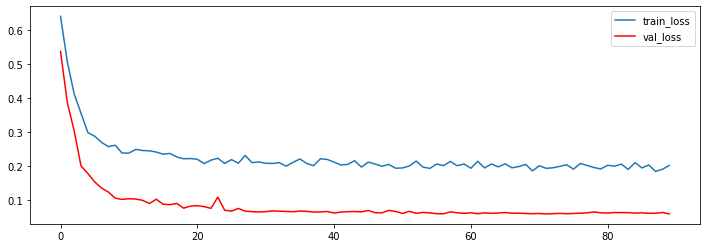

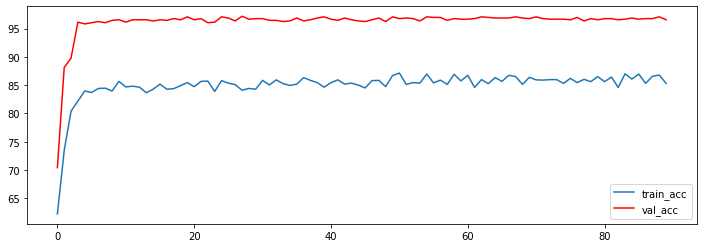

In [18]:
meter.plot()

- AdamW e80 step 20 gamma 0.3  
Train loss: 0.0941 acc: 96.34 - Test loss: 0.0773 acc: 96.77  
Train loss: 0.0911 acc: 96.34 - Test loss: 0.0856 acc: 96.56  
- SGD mementum 0.9  
Train loss: 0.0852 acc: 96.88 - Test loss: 0.0999 acc: 96.56
- model 20,5,5,5,1  
Train loss: 0.0865 acc: 96.56 - Test loss: 0.0979 acc: 96.35  
Train loss: 0.0946 acc: 96.34 - Test loss: 0.0746 acc: 97.29 gamma 0.1

- model 20,5,1 gamma=0.1 SGD  
Train loss: 0.0922 acc: 96.47 - Test loss: 0.0868 acc: 96.77

In [19]:
# torch.save('ckpts/supervised_acc9625.pt')